In [1]:
#JV

I am taking the following Approach:

1. I am trying to build each of the specified functionality in this notebook
2. Upon wirting correct code for a functionality, I would add it to the final python file, in the same dir

So, the efforts and the incremental progress can be seen by checking the versions of this notebook (.ipynb)
and the best version of the functionalities (for different questions) would incrementally be added to the .py file

In [2]:
from keras.datasets import fashion_mnist,mnist
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gc
import time
import wandb
from sklearn.metrics import confusion_matrix
import networkx as nx

#### Question 1 : MNIST import and Plot Classes

In [3]:
## Importing the data

"""unpacking data returned by load_data(), as specified in keras docs"""
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()

""" Merging the data to perform a random train-test split """
X = np.concatenate((x_train,x_test))
Y = np.concatenate((y_train,y_test))

In [4]:
## this has to be logged only once, so uncomment if needed again
#wandb.init(project="JV_CS23M036_TEJASVI_DL_ASSIGNMENT1", name="mnist-fashion-viz")

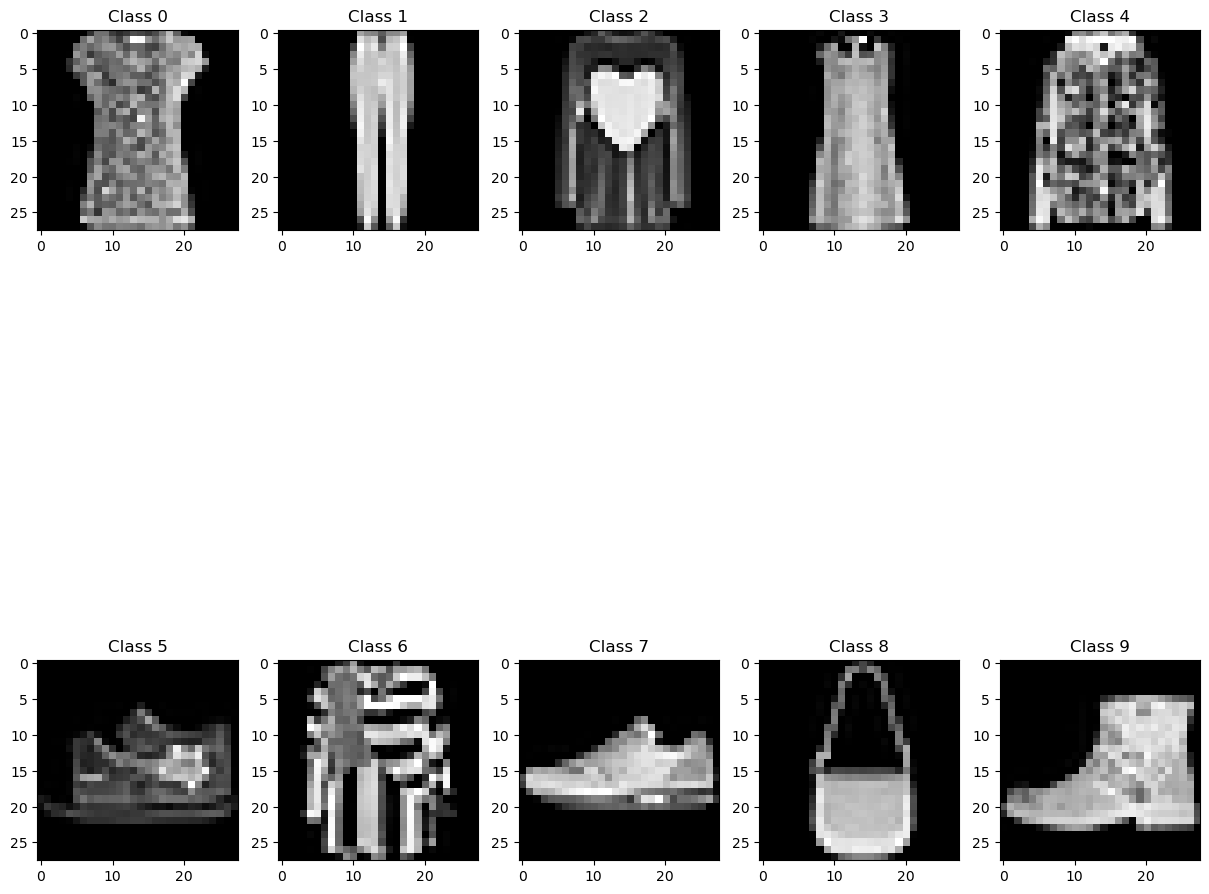

In [5]:
#Plotting 1 image per class

""" For each class, identify an index at which the correspondingimage can be found"""
classwise_indices_of_image_in_data = [np.where(Y==i)[0][-1] for i in range(10)]

""" plotting """
rows_in_plot = 2
cols_in_plot = 5

fig, ax = plt.subplots(rows_in_plot, cols_in_plot, figsize=(15, 15))

for i in range(rows_in_plot):
    for j in range(cols_in_plot):

        id = i*cols_in_plot+j
        ax[i,j].set_title("Class "+str(id))
        ax[i,j].imshow(X[classwise_indices_of_image_in_data[id]],cmap=plt.get_cmap('gray'))
    
        #wandb.log({"Fashion MNIST Class Visualization": fig})

#wandb.finish()




#### Question 2 : Create Neural Network and Implement Forward Pass

In [6]:
class Initializer:
    """
    Class containing methods to initialize parameters of neural network.
    """

    def __init__(self,seed=2):
        """
        Default constructor

        params:

            seed : Default seed, for an instance of this class, used for initialization.
        
        """

        self.random_num_generator = np.random.RandomState(seed)
        

    def random(self,shape,distribution="normal",param1=0,param2=0.2):
        """
        Method to perform random initialization.

        params:

            shape: The shape of the numpy array that has to be initialized.
            distribution : "normal" or "uniform"; default is "normal".
            param1 : mean of normal or lower limit of random uniform.
            param2 : stddev of normal or upper limit of random normal.

        Returns:

            a numpy array of the given shape after random (uniform/normal) initialization.
        """

        if distribution == "normal":

            return self.random_num_generator.normal(param1,param2,size=shape)


        elif distribution == "uniform":

            return self.random_num_generator.uniform(param1,param2,size=shape)


    def xavier(self,shape,distribution="normal",fanIn=1,fanOut=1,isBiases=False):

        """
        
        Method to initialize parameters of a neural network, according to xavier initialization.
        
        params:

            shape: The shape of the numpy array that has to be initialized.
            distribution : "normal" or "uniform"; default is "normal".
            fanIn : Number of neurons in the previous layer. Default is 1.
            fanOut : Number of neurons in the next layer. Default is 1.
            isBiases : As per the original paper on xavier initialization, biases are initialzied to zero. Following the same.

        Returns:

            a numpy array of the given shape after xavier(uniform/normal) initialization.
        
        """

        if isBiases:

            return np.zeros((shape))

        if distribution == "normal":

            mu = 0
            sigma = np.sqrt(2/(fanIn+fanOut))

            return self.random_num_generator.normal(mu,sigma,size=shape)

        elif distribution == "uniform":

            bound = np.sqrt(6/(fanIn+fanOut))

            return self.random_num_generator.uniform(-bound,bound,size=shape)

            

### Activation Functions Class

In [7]:
class Activation:

    """
    A class containing methods of activation functions to be applied to the layers of the Neural Network.

    Currently supported Activations : sigmoid, tanh and ReLu

    More activation functions can be added as required by adding a method.
    """

    def __init__(self):
        """
        Default Constructor
        """
        pass

    def sigmoid(self,x):
        """
        A method to immplement logistic version of sigmoid activation function.

        Params:
            x : numpy array

        Returns:
            Array after applying sigmoid
        """

        return 1/(1+np.exp(-x))

    
    def tanh(self,x):
        """
        A method to immplement tanh activation.

        Params:
            x : numpy array

        Returns:
            Array after applying tanh
        """

        
        return np.tanh(x)


    def ReLu(self,x):
        """
        A method to immplement ReLu activation.

        Params:
            x : numpy array

        Returns:
            Array after applying ReLu        
        """

        return np.maximum(x,0)

    def identity(self,x):

        """
        A method to immplement identity activation.

        Params:
            x : numpy array

        Returns:
            Input as is.        
        """
        
        return x

    def softmax(Self,x):
        """
        A method that returns the softmax of the input vector.

        Mostly meant for the activation of the output layer.

        params:
            x: numpy array

        returns:
            softmax transformed input.
        
        """

        return np.exp(x)/np.sum(np.exp(x))
    

#### Gradient of Activation Class

In [8]:
class Activation_Gradient:

    """
    Class to provide a method which evaluates the gradient of the activation used at a point x in the space.

    To avoid the use of autograd/diff packages, the closed form of the derivatives is computed before hand and plugged in here.

    Such an approach is taken to build and train a neural network from scratch, instead of depending on existing libraries.

    This new activation functions can easily be added by creating a method that evaluates the closed form of the derivative at any given point x.
    and an appropriate elif condition must be added.
    """

    def grad_ReLu(self,x):

        x[x<=0] = 0
        x[x>0] = 1

        return x

    def grad_tanh(self,x):

        return 1-(np.tanh(x))**2

    def grad_sigmoid(self,x):

        logistic =  1/(1+np.exp(-x))

        return logistic*(1-logistic)

    def grad_identity(self,x):

        return np.ones(x.shape)


    def grad_activation(self,x,activation="ReLu"):

        """
        params:
    
            activation : currently supported : "ReLu" [Default] ,"tanh",sigmoid".
    
        returns:
    
            An invokable method that produces deriviative of the activation function evaluated at x.
        
        """

        if activation=="ReLu":
            return self.grad_ReLu(x)
    
        elif activation=="tanh":
            return self.grad_tanh(x)
    
        elif activation=="sigmoid":
            return self.grad_sigmoid(x)
    
        elif activation=="identity":
            return self.grad_identity(x)

        

### Neural Network Class

Has methods to:
* Create a specified architecure, setup weights and biases
* Forward propagation
* Back Propagation

In [9]:
class NeuralNetwork:
    """
        A class containing methods to create a neural network, perform forward pass (prediction) and backpropogation/training
    """
    def __init__(self,seed=36):
        
        self.seed = seed


    def createNNet(self,input_neurons=784,output_neurons=10,number_of_hidden_layers=3,neurons_per_hidden_layer=[32]*3,initialization = "random",activation="sigmoid",output_activation = "softmax"):

        """
        Method to create a neural network, with specified number of inputs, outputs, hidden layers and neurons per hidden layer,

        with specified activation, output.

        With the weights and biases initialized as per the specified initialization strategy

        Params:

            input_neurons (default=784): Number of input features.
            
            output_neurons (default=10): Number of outputs.
            
            number_of_hidden_layers (default=3): Number of hidden layers.
            
            neurons_per_hidden_layer (default=[32]*3): List of number of neurons per hidden layer.
            
            initialization (default="random"): Parameter initialization process : "random normal" or "xavier normal"
            
            activation (default="sigmoid"): Activation function for all the hidden layers ("sigmoid","ReLu","tanh","identity")
            
            output_activation (default="softmax"): Activation function for the output layer ("softmax","linear")

        Returns:

            None.
        
        """


        ## setup the variables governing the network's architecture
        
        self.input_neurons = input_neurons
        self.output_neurons = output_neurons
        
        self.number_of_hidden_layers = number_of_hidden_layers
        self.neurons_per_hidden_layer = neurons_per_hidden_layer
        self.neurons_per_layer = [input_neurons] + self.neurons_per_hidden_layer + [output_neurons]


        ## Compute the shape of biases and weights in the direction of input to output
        
        self.weight_shapes = [(self.neurons_per_layer[i+1],self.neurons_per_layer[i]) for i in range(len(self.neurons_per_layer)-1)]
        self.bias_shapes = self.neurons_per_layer[1:]
        

        ## setup and get a handle on the initializer
        
        init_obj = Initializer(seed=self.seed)

        if initialization == "random":

            self.intializer = init_obj.random

        elif initialization == "xavier":

            self.intializer = init_obj.xavier


        ## Weights and biases are stored as list of numpy arrays
        ## They are orgnaized from the first hidden layer (closest to input) to the last hidden layer.
        
        
        self.weights = []
        self.biases = []


        if initialization == "random":
            
            for i in range(self.number_of_hidden_layers+1):
            
                self.weights.append(self.intializer(self.weight_shapes[i]))
                self.biases.append(self.intializer(self.bias_shapes[i]))
            

        elif initialization == "xavier":

                ## as per the standard convention
                ## Wi is the weight matrix for the layer i [consider from i>=1]
                ## its fanIn would be the number of neurons in layer i-1
                ## fanOut would be the number of neurons in layer i+1
                ## for the weights that lead to the output layer, fanout would be 1
                ## This is inferred from the original paper on xavier initialization.
                

            for i in range(1,self.number_of_hidden_layers+2):

                
                fanIn = self.neurons_per_layer[i-1]
                
                if i == self.number_of_hidden_layers+1: ## if it is the output layer
                    fanOut = 1

                else:  ## for the hidden layers
                    fanOut = self.neurons_per_layer[i+1]

                self.weights.append(self.intializer(shape=self.weight_shapes[i-1],distribution="uniform",fanIn=fanIn,fanOut=fanOut))
                self.biases.append(self.intializer(shape=self.bias_shapes[i-1],isBiases=True))



        activation_obj = Activation()
                
        if activation == "sigmoid":
                
            self.activation = activation_obj.sigmoid
            
        elif activation == "tanh":
                
            self.activation = activation_obj.tanh

        elif activation == "ReLu":
                
            self.activation = activation_obj.ReLu

        elif activation == "identity":

            self.activation = activation_obj.identity

        output_obj = Activation()

        if output_activation == "softmax":

            self.output_activation = output_obj.softmax


    def forward(self,x,weights = "default",biases="default"):

        """
        Method to perform the forward pass on the neural network and return the outputs.

        params:

            x : Numpy array, the input vector.
            weights : By default they are the network's weights, but to support nestorov based optimisers, where a look ahead based gradient is computed, this parameter support would be required.
            biases : By default they are the network's biases, but to support nestorov based optimisers, where a look ahead based gradient is computed, this parameter support would be required.
        Returns : 

            output numpy array as the result of forward propagation of the input through the network.
        
        """

        if type(weights) == str:
            weights = self.weights
            biases = self.biases
            
        
        a = [] ## list of layer wise pre-activation outputs
        h = [x] ## h0 is input. This is list of post activation outputs, except final output
         
        
        cur_out = x
        
        for i in range(self.number_of_hidden_layers+1):

            
            ai = weights[i]@cur_out+biases[i] ## compute pre activation output ith layer
            
            if i == self.number_of_hidden_layers:
                
                output = self.output_activation(ai)

            else:
                cur_out = self.activation(ai) ## post activation output of the ith (non-output) layer
                h.append(cur_out)

            a.append(ai)
                
        return a,h,output

    def backprop(self,a,h,y_true,y_pred,weights="default",biases="default",loss="cross entropy"):


        """
        Method to perform the backpropagation in the network to compute and return the gradients w.r.t the parameters.

        Params:
            a : List of pre-activation values collected during forward pass.
            h : List of post-activation values for hidden layers collected during forward pass.
            y_true : One hot encoding of the true input label for a specific input.
            y_pred : The predicted class distribution for the same input.
            weights : By default they are the network's weights, but to support nestorov based optimisers, where a look ahead based gradient is computed, this parameter support would be required.
            biases : By default they are the network's biases, but to support nestorov based optimisers, where a look ahead based gradient is computed, this parameter support would be required.
            loss : The loss function used, default is cross entropy. Accordingly the gradient computation would change. Default : "cross entropy"

            Note:

                 Squared error loss is assumed to be computed on the outputs of softmax, which are probabilities of each class.
                 This is restrictive in the sense that this network may not work for a regression problem, but still such an 
                 assumption is made to meet the requirements of what's asked in the assignment.
            
        Returns:

            The list of layer wise gradients.
        
        """

        if type(weights) == str:  ## which means that weights and biases are "default", then set them to the network's weights.
            weights = self.weights
            biases = self.biases

        activation_grad = Activation_Gradient()

        dw_list = [] ## list of gradients of weights from last layer to 1st layer

        db_list = [] ## list of gradients of biases from last layer to 1st layer

        
        if loss == "cross entropy":
            grad_aL = -(y_true-y_pred)  ## gradient of loss w.r.t pre-activation of output layer

        elif loss == "squared error":
            grad_aL = 2*(y_pred-y_true)*y_pred*(1-y_pred) ## derived this closed form expression by hand.

        grad_ai = grad_aL

        for i in range(self.number_of_hidden_layers,-1,-1):

            
            grad_Wi = np.outer(grad_ai,h[i]) ## gradient of loss w.r.t weights of ith layer. it's h[i] as per the algo, but to adjust indexing to access the right element, h[i] is used

            dw_list.append(grad_Wi)
            
            grad_bi = grad_ai ## gradient of loss w.r.t biases of ith layer.
            db_list.append(grad_bi)

            if(i>0): ## i.e only if a layer is present before the current layer

                grad_h_prev = weights[i].T @ grad_ai ## gradient of loss w.r.t activation of previous layer
    
                grad_a_prev = grad_h_prev * activation_grad.grad_activation(a[i-1],self.activation.__name__) ##gradient of loss wrt pre-activation of previous layer
    
                grad_ai = grad_a_prev

        return dw_list, db_list


### Optimiser Class

*Has methods for SGD, Momentum GD, Nesterov Acclerated GD, RMSProp, Adam, nesterov accelerated Adam* 

In [10]:
class Optimiser:

    """
    A class containing methods of optimizers including

        Stochastic Gradient Descent (sgd)
        Gradient Desecent with Momentum (gd_momentum)
        Nesterov accelerated Gradient Descent (nesterov_gd)
        rmsprop (rmsprop)
        adam (adam)
        nadam (nadam)
    """

    def compute_accuracy(self,nn,data,return_stats=False,loss_type="cross entropy",print_stats=True,type_of_data="Validation",epoch=0,log_wandb_data=False,return_confusion_matrix=False):

        """
        A helping method for the optimiser methods. It takes the current neural network object and data, and returns the accuracy and loss over the data.

        Params:

            nn : Neural Network object, using which neural network's forward and backprop can be accessed.
            data : Expected to be in the form [x_data,y_data], where x_data and y_data are numpy arrays, which may have train/validation/test data.
            return_stats : A boolean variable that indicates if stats have to be returned. Default is False.
            loss_type  : "cross entropy" or "mse", as of now only supports specific loss functions, the ones whose closed form gradients for backprop is known. Default is "cross entropy".
            print_stats : True (default), if the stats (accuracy and loss) have to be printed.
            type_of_data : "train","test" or "validation", its used to label while printing the accuracy/loss. Default is "Validation"
            epoch : The epoch at which the stats are being computed (optional,default 0).
            log_wandb_data : If true data is logged when wandb logging is required.
            
        """

        x_data,y_data = data

        list_of_predicted_classes = []

        loss = 0
    
        for i in range(x_data.shape[0]):
    
            _,_,prediction_probs = nn.forward(x_data[i])
            list_of_predicted_classes.append(np.argmax(prediction_probs)) ## computing predicted class would be the same irrespective of the loss function


            if loss_type == "cross entropy":
                loss += -np.log(prediction_probs[y_data[i]]) ##cross entropy loss

            elif loss_type == "squared error":

                ## making a one-hot encoding of the true class; this can also be seen as the true prob. distribution.
                y_true = np.zeros((nn.output_neurons))
                y_true[y_data[i]]  = 1
                
                loss += np.sum(np.square(prediction_probs-y_true))

    
        unique,counts = np.unique(np.array(list_of_predicted_classes) == y_data, return_counts=True)
    
        accuracy = dict(zip(unique, counts))[True]/y_data.shape[0]

        accuracy = round(accuracy*100,2)

        loss = round(loss/y_data.shape[0],2)
        

        if log_wandb_data:
                if "train" in type_of_data.lower():
                    wandb.log({'train loss': loss, 'train accuracy': accuracy, 'epoch': epoch+1})

                elif "val" in  type_of_data.lower():

                    wandb.log({'val_accuracy': accuracy})

        if print_stats:
            
            print(f"{type_of_data} Accuracy : {accuracy}%  Avg. Loss : {loss}")

        if return_confusion_matrix:

            return confusion_matrix(y_data,list_of_predicted_classes)

        if return_stats:
            return accuracy,loss
            

    def sgd(self,nn,train_data,val_data,lr=1e-3,epochs=5,batch_size=1,l2_param=0,print_val_accuracy=True,loss_type="cross entropy",log_wandb_data=False):

        """
        Method performs the stochastic gradient descent with default batch size as 1; increasing batch size makes it mini batch version.
        
        params:

            nn : An object corresponding to an initalized or ready neural network

            lr : learning rate parameter (default  :1e-3)

            epochs : number of training epochs (default : 5)

            batch size : mini batch size, default is 1

            l2_param : l2_regularization coefficient, default is 0.

            loss_type  : "cross entropy" or "mse", as of now only supports specific loss functions, the ones whose closed form gradients for backprop is known. Default is "cross entropy".
            
            log_wandb_data : If true data is logged when wandb logging is required.

        returns:

            None.
        
        """

        x_train = train_data[0]
        y_train = train_data[1]

        for epoch in tqdm(range(epochs)):

            dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            points_seen = 0
            
            for i in tqdm(range(y_train.shape[0])):


                #create a one hot encoding of the true label
                y_true = np.zeros(nn.output_neurons)
                y_true[y_train[i]] = 1

                a,h,y_pred_probs = nn.forward(x_train[i].flatten()) ## apply forward pass on input
                
                dw_cur,db_cur = nn.backprop(a,h,y_true,y_pred_probs,loss=loss_type) ## backprop now
                

                dw_cur.reverse() ##dw returned by backprop are from last layer to first layer weights, hence reversing
                db_cur.reverse() ##db returned by backprop are from last layer to first layer weights, hence reversing
                
                ## accumulate gradients of Weights and Biases.
                dw = list(np.array(dw,dtype=object) + np.array(dw_cur,dtype=object))
                
                db = list(np.array(db,dtype=object) + np.array(db_cur,dtype=object))
                
                points_seen += 1

                if(points_seen%batch_size == 0): ## seen mini batch number of points so update the parameters now


                    nn.weights = list(np.array(nn.weights,dtype = object) - lr*(1+l2_param)*np.array(dw,dtype=object))
                    nn.biases = list(np.array(nn.biases,dtype = object) - lr*(1+l2_param)*np.array(db,dtype=object))

                    #reset the grads of weights and biases
                    dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
                    db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
                    
            if print_val_accuracy: ##if true, prints validation accuracy after the current epoch.
            
                self.compute_accuracy(nn,train_data,print_stats=True,type_of_data="Training  ",epoch=epoch,loss_type=loss_type,log_wandb_data=log_wandb_data)
                self.compute_accuracy(nn,val_data,print_stats=True,type_of_data="Validation",epoch=epoch,loss_type=loss_type,log_wandb_data=log_wandb_data)


    def gd_momentum(self,nn,train_data,val_data,lr=1e-3,epochs=5,batch_size=1,l2_param=0,print_val_accuracy=True,loss_type="cross entropy",momentum=0.9,log_wandb_data=False):

        """
        Method performs the stochastic gradient descent with momentum and a default batch size as 1; increasing batch size makes it mini batch version.
        
        params:

            nn : An object corresponding to an initalized or ready neural network

            lr : learning rate parameter (default  :1e-3)

            epochs : number of training epochs (default : 5)

            batch size : mini batch size, default is 1

            l2_param : l2_regularization coefficient, default is 0.

            momentum : The momentum parameter. Default is 0.9

            loss_type  : "cross entropy" or "mse", as of now only supports specific loss functions, the ones whose closed form gradients for backprop is known. Default is "cross entropy".

            log_wandb_data : If true data is logged when wandb logging is required.

        returns:

            None.
        
        """

        x_train = train_data[0]
        y_train = train_data[1]

        for epoch in tqdm(range(epochs)):

            dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]

            prev_uw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            prev_ub = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            
            points_seen = 0
            
            for i in tqdm(range(y_train.shape[0])):


                #create a one hot encoding of the true label
                y_true = np.zeros(nn.output_neurons)
                y_true[y_train[i]] = 1

                a,h,y_pred_probs = nn.forward(x_train[i].flatten()) ## apply forward pass on input
                
                dw_cur,db_cur = nn.backprop(a,h,y_true,y_pred_probs,loss=loss_type) ## backprop now
                

                dw_cur.reverse() ##dw returned by backprop are from last layer to first layer weights, hence reversing
                db_cur.reverse() ##db returned by backprop are from last layer to first layer weights, hence reversing
                
                ## accumulate gradients of Weights and Biases.
                dw = list(np.array(dw,dtype=object) + np.array(dw_cur,dtype=object))
                
                db = list(np.array(db,dtype=object) + np.array(db_cur,dtype=object))
                
                points_seen += 1

                if(points_seen%batch_size == 0): ## seen mini batch number of points so update the parameters now

                    uw = momentum*np.array(prev_uw,dtype=object) + lr*np.array(dw,dtype=object)
                    ub = momentum*np.array(prev_ub,dtype=object) + lr*np.array(db,dtype=object)
                    
                    nn.weights = list(np.array(nn.weights,dtype = object) - uw  - lr*l2_param*np.array(dw,dtype=object))
                    nn.biases = list(np.array(nn.biases,dtype = object) - ub - lr*l2_param*np.array(db,dtype=object))

                    #reset the grads of weights and biases
                    dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
                    db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]

                    prev_uw = uw
                    prev_ub = ub
                    
            if print_val_accuracy: ##if true, prints validation accuracy after the current epoch.
            
                self.compute_accuracy(nn,train_data,print_stats=True,type_of_data="Training  ",epoch=epoch,loss_type=loss_type,log_wandb_data=log_wandb_data)
                self.compute_accuracy(nn,val_data,print_stats=True,type_of_data="Validation",epoch=epoch,loss_type=loss_type,log_wandb_data=log_wandb_data)

    def gd_nesterov(self,nn,train_data,val_data,lr=1e-3,epochs=5,batch_size=1,l2_param=0,print_val_accuracy=True,loss_type="cross entropy",momentum=0.9,log_wandb_data=False):

        """
        Method performs the Nesterov Accelerated gradient descent with default batch size as 1; increasing batch size makes it mini batch version.
        
        params:

            nn : An object corresponding to an initalized or ready neural network

            lr : learning rate parameter (default  :1e-3)

            epochs : number of training epochs (default : 5)

            batch size : mini batch size, default is 1

            l2_param : l2_regularization coefficient, default is 0.

            momentum : The momentum parameter. Default is 0.9

            loss_type  : "cross entropy" or "mse", as of now only supports specific loss functions, the ones whose closed form gradients for backprop is known. Default is "cross entropy".

            log_wandb_data : If true data is logged when wandb logging is required.

        returns:

            None.
        
        """

        x_train = train_data[0]
        y_train = train_data[1]

        
        for epoch in tqdm(range(epochs)):

        
            dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]

            prev_uw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            prev_ub = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]

            u_w = momentum*np.array(prev_uw,dtype=object) ## this is the nesterov look ahead in terms of weights
            u_b = momentum*np.array(prev_ub,dtype=object) ## this is the nesterov look ahead in terms of weights
            
            points_seen = 0
            
            for i in tqdm(range(y_train.shape[0])):


                #create a one hot encoding of the true label
                y_true = np.zeros(nn.output_neurons)
                y_true[y_train[i]] = 1

                look_ahead_weights = np.array(nn.weights,dtype=object) - u_w
                look_ahead_biases = np.array(nn.biases,dtype=object) - u_b
                
                a,h,y_pred_probs = nn.forward(x_train[i].flatten(),weights=look_ahead_weights,biases=look_ahead_biases) ## apply forward pass on input
                
                dw_cur,db_cur = nn.backprop(a,h,y_true,y_pred_probs,weights=look_ahead_weights,biases=look_ahead_biases,loss=loss_type) ## backprop now
                

                dw_cur.reverse() ##dw returned by backprop are from last layer to first layer weights, hence reversing
                db_cur.reverse() ##db returned by backprop are from last layer to first layer weights, hence reversing
                
                ## accumulate gradients of Weights and Biases.
                dw = list(np.array(dw,dtype=object) + np.array(dw_cur,dtype=object))
                
                db = list(np.array(db,dtype=object) + np.array(db_cur,dtype=object))
                
                points_seen += 1

                if(points_seen%batch_size == 0): ## seen mini batch number of points so update the parameters now

                    uw = momentum*np.array(prev_uw,dtype=object) + lr*np.array(dw,dtype=object)
                    ub = momentum*np.array(prev_ub,dtype=object) + lr*np.array(db,dtype=object)
                    
                    nn.weights = list(np.array(nn.weights,dtype = object) - uw  - lr*l2_param*np.array(dw,dtype=object))
                    nn.biases = list(np.array(nn.biases,dtype = object) - ub - lr*l2_param*np.array(db,dtype=object))

                    #reset the grads of weights and biases
                    dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
                    db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]

                    prev_uw = uw
                    prev_ub = ub

                    u_w = momentum*np.array(prev_uw,dtype=object) ## this is the nesterov look ahead in terms of weights
                    u_b = momentum*np.array(prev_ub,dtype=object) ## this is the nesterov look ahead in terms of weights
                    
            if print_val_accuracy: ##if true, prints validation accuracy after the current epoch.
            
                self.compute_accuracy(nn,train_data,print_stats=True,type_of_data="Training  ",epoch=epoch,loss_type=loss_type,log_wandb_data=log_wandb_data)
                self.compute_accuracy(nn,val_data,print_stats=True,type_of_data="Validation",epoch=epoch,loss_type=loss_type,log_wandb_data=log_wandb_data)


    def rmsprop(self,nn,train_data,val_data,lr=1e-3,epochs=5,batch_size=1,l2_param=0,print_val_accuracy=True,loss_type="cross entropy",beta=0.5,epsilon=1e-4,log_wandb_data=False):

        """
        Method performs RMSprop with default batch size as 1; increasing batch size makes it mini batch version.
        
        params:

            nn : An object corresponding to an initalized or ready neural network

            lr : learning rate parameter (default  :1e-3)

            epochs : number of training epochs (default : 5)

            batch size : mini batch size, default is 1

            l2_param : l2_regularization coefficient, default is 0.

            beta : The beta in rms prop, default is 0.5

            epsilon : The epsilon in rms prop, default is 1e-4

            loss_type  : "cross entropy" or "mse", as of now only supports specific loss functions, the ones whose closed form gradients for backprop is known. Default is "cross entropy".
            
            log_wandb_data : If true data is logged when wandb logging is required.

        returns:

            None.
        
        """

        x_train = train_data[0]
        y_train = train_data[1]


        ## initialize the v arrays used in rmsprop algo
        v_w = np.array([np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)],dtype=object)
        v_b = np.array([np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)],dtype=object)


        for epoch in tqdm(range(epochs)):

            dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            
            points_seen = 0
            
            for i in tqdm(range(y_train.shape[0])):


                #create a one hot encoding of the true label
                y_true = np.zeros(nn.output_neurons)
                y_true[y_train[i]] = 1

                a,h,y_pred_probs = nn.forward(x_train[i].flatten()) ## apply forward pass on input
                
                dw_cur,db_cur = nn.backprop(a,h,y_true,y_pred_probs,loss=loss_type) ## backprop now
                

                dw_cur.reverse() ##dw returned by backprop are from last layer to first layer weights, hence reversing
                db_cur.reverse() ##db returned by backprop are from last layer to first layer weights, hence reversing
                
                ## accumulate gradients of Weights and Biases.
                dw = list(np.array(dw,dtype=object) + np.array(dw_cur,dtype=object))
                
                db = list(np.array(db,dtype=object) + np.array(db_cur,dtype=object))
                
                points_seen += 1

                if(points_seen%batch_size == 0): ## seen mini batch number of points so update the parameters now

                    v_w = beta*v_w + (1-beta)*np.array(dw,dtype=object)**2
                    v_b = beta*v_b + (1-beta)*np.array(db,dtype=object)**2

                    
                    ## v_w is a numpy array of different shaped arrays
                    ## and is of type object
                    ## so np.sqrt won't directly work
                    vw_denominator = v_w
                    vb_denominator = v_b

                    for ii in range(v_w.shape[0]):
                        vw_denominator[ii] = np.sqrt(v_w[ii])+epsilon

                    for ii in range(v_b.shape[0]):
                        vb_denominator[ii] = np.sqrt(v_b[ii])+epsilon

                    
                    
                    nn.weights = list(np.array(nn.weights,dtype = object) - lr*np.array(dw,dtype=object)/vw_denominator  - lr*l2_param*np.array(dw,dtype=object))
                    nn.biases = list(np.array(nn.biases,dtype = object) - lr*np.array(db,dtype=object)/vb_denominator - lr*l2_param*np.array(db,dtype=object))

                    #reset the grads of weights and biases
                    dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
                    db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]

                    
            if print_val_accuracy: ##if true, prints validation accuracy after the current epoch.
            
                self.compute_accuracy(nn,train_data,print_stats=True,type_of_data="Training  ",epoch=epoch,loss_type=loss_type,log_wandb_data=log_wandb_data)
                self.compute_accuracy(nn,val_data,print_stats=True,type_of_data="Validation",epoch=epoch,loss_type=loss_type,log_wandb_data=log_wandb_data)
                

    def adam(self,nn,train_data,val_data,lr=1e-3,epochs=5,batch_size=1,l2_param=0,print_val_accuracy=True,loss_type="cross entropy",beta1=0.9,beta2=0.999,epsilon=1e-8,log_wandb_data=False):

        """
        Method performs Adam, with default batch size as 1; increasing batch size makes it mini batch version.
        
        params:

            nn : An object corresponding to an initalized or ready neural network

            lr : learning rate parameter (default  :1e-3)

            epochs : number of training epochs (default : 5)

            batch size : mini batch size, default is 1

            l2_param : l2_regularization coefficient, default is 0.

            beta1 : The beta1 in adam, default is 0.9

            beta2 : The beta2 in adam, default is 0.999

            epsilon : The epsilon, default is 1e-8

            loss_type  : "cross entropy" or "mse", as of now only supports specific loss functions, the ones whose closed form gradients for backprop is known. Default is "cross entropy".
            
            log_wandb_data : If true data is logged when wandb logging is required.

        returns:

            None.
        
        """

        x_train = train_data[0]
        y_train = train_data[1]


        ## to keep track of the total number of network parameter updates, because it depends on batch size
        ## so better track it.
        update_count = 0
        
        ## initialize the m,v arrays used in adam algo

        m_w = np.array([np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)],dtype=object)
        m_b = np.array([np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)],dtype=object)
        
        v_w = np.array([np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)],dtype=object)
        v_b = np.array([np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)],dtype=object)


        for epoch in tqdm(range(epochs)):


            dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            
            points_seen = 0
            
            for i in tqdm(range(y_train.shape[0])):


                #create a one hot encoding of the true label
                y_true = np.zeros(nn.output_neurons)
                y_true[y_train[i]] = 1

                a,h,y_pred_probs = nn.forward(x_train[i].flatten()) ## apply forward pass on input
                
                dw_cur,db_cur = nn.backprop(a,h,y_true,y_pred_probs,loss=loss_type) ## backprop now
                

                dw_cur.reverse() ##dw returned by backprop are from last layer to first layer weights, hence reversing
                db_cur.reverse() ##db returned by backprop are from last layer to first layer weights, hence reversing
                
                ## accumulate gradients of Weights and Biases.
                dw = list(np.array(dw,dtype=object) + np.array(dw_cur,dtype=object))
                
                db = list(np.array(db,dtype=object) + np.array(db_cur,dtype=object))
                
                points_seen += 1

                if(points_seen%batch_size == 0): ## seen mini batch number of points so update the parameters now

                    update_count += 1


                    m_w = beta1*m_w + (1-beta1)*np.array(dw,dtype=object)
                    m_b = beta1*m_b + (1-beta1)*np.array(db,dtype=object)
                    
                    v_w = beta2*v_w + (1-beta2)*np.array(dw,dtype=object)**2
                    v_b = beta2*v_b + (1-beta2)*np.array(db,dtype=object)**2


                    m_w_hat = m_w/(1-np.power(beta1,update_count))
                    m_b_hat = m_b/(1-np.power(beta1,update_count))
                    v_w_hat = v_w/(1-np.power(beta2,update_count))
                    v_b_hat = v_b/(1-np.power(beta2,update_count))

                    
                    ## v_w_hat is a numpy array of different shaped arrays
                    ## and is of type object
                    ## so np.sqrt won't directly work
                    vw_hat_denominator = v_w_hat
                    vb_hat_denominator = v_b_hat

                    for ii in range(v_w_hat.shape[0]):
                        vw_hat_denominator[ii] = np.sqrt(v_w_hat[ii])+epsilon

                    for ii in range(v_b_hat.shape[0]):
                        vb_hat_denominator[ii] = np.sqrt(v_b_hat[ii])+epsilon

                    
                    
                    nn.weights = list(np.array(nn.weights,dtype = object) - lr*m_w_hat/vw_hat_denominator  - lr*l2_param*np.array(dw,dtype=object))
                    nn.biases = list(np.array(nn.biases,dtype = object) - lr*m_b_hat/vb_hat_denominator - lr*l2_param*np.array(db,dtype=object))

                    #reset the grads of weights and biases
                    dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
                    db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]

                    
            if print_val_accuracy: ##if true, prints validation accuracy after the current epoch.
            
                self.compute_accuracy(nn,train_data,print_stats=True,type_of_data="Training  ",epoch=epoch,loss_type=loss_type,log_wandb_data=log_wandb_data)
                self.compute_accuracy(nn,val_data,print_stats=True,type_of_data="Validation",epoch=epoch,loss_type=loss_type,log_wandb_data=log_wandb_data)
                

    def nadam(self,nn,train_data,val_data,lr=1e-3,epochs=5,batch_size=1,l2_param=0,print_val_accuracy=True,loss_type="cross entropy",beta1=0.9,beta2=0.999,epsilon=1e-8,log_wandb_data=False):

        """
        Method performs Nesterov Accelerated Adam, with default batch size as 1; increasing batch size makes it mini batch version.
        
        params:

            nn : An object corresponding to an initalized or ready neural network

            lr : learning rate parameter (default  :1e-3)

            epochs : number of training epochs (default : 5)

            batch size : mini batch size, default is 1

            l2_param : l2_regularization coefficient, default is 0.

            beta1 : The beta1 in nadam, default is 0.9

            beta2 : The beta2 in nadam, default is 0.999

            epsilon : The epsilon, default is 1e-8

            loss_type  : "cross entropy" or "mse", as of now only supports specific loss functions, the ones whose closed form gradients for backprop is known. Default is "cross entropy".

            log_wandb_data : If true data is logged when wandb logging is required.

        returns:

            None.
        
        """

        x_train = train_data[0]
        y_train = train_data[1]


        ## to keep track of the total number of network parameter updates, because it depends on batch size
        ## so better track it.
        update_count = 0
        
        ## initialize the m,v arrays used in adam algo

        m_w = np.array([np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)],dtype=object)
        m_b = np.array([np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)],dtype=object)
        
        v_w = np.array([np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)],dtype=object)
        v_b = np.array([np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)],dtype=object)


        for epoch in tqdm(range(epochs)):

            dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            
            points_seen = 0
            
            for i in tqdm(range(y_train.shape[0])):


                #create a one hot encoding of the true label
                y_true = np.zeros(nn.output_neurons)
                y_true[y_train[i]] = 1

                a,h,y_pred_probs = nn.forward(x_train[i].flatten()) ## apply forward pass on input
                
                dw_cur,db_cur = nn.backprop(a,h,y_true,y_pred_probs,loss=loss_type) ## backprop now
                

                dw_cur.reverse() ##dw returned by backprop are from last layer to first layer weights, hence reversing
                db_cur.reverse() ##db returned by backprop are from last layer to first layer weights, hence reversing
                
                ## accumulate gradients of Weights and Biases.
                dw = list(np.array(dw,dtype=object) + np.array(dw_cur,dtype=object))
                
                db = list(np.array(db,dtype=object) + np.array(db_cur,dtype=object))
                
                points_seen += 1

                if(points_seen%batch_size == 0): ## seen mini batch number of points so update the parameters now

                    update_count += 1


                    m_w = beta1*m_w + (1-beta1)*np.array(dw,dtype=object)
                    m_b = beta1*m_b + (1-beta1)*np.array(db,dtype=object)
                    
                    v_w = beta2*v_w + (1-beta2)*np.array(dw,dtype=object)**2
                    v_b = beta2*v_b + (1-beta2)*np.array(db,dtype=object)**2


                    m_w_hat = m_w/(1-np.power(beta1,update_count))
                    m_b_hat = m_b/(1-np.power(beta1,update_count))
                    v_w_hat = v_w/(1-np.power(beta2,update_count))
                    v_b_hat = v_b/(1-np.power(beta2,update_count))

                    
                    ## v_w_hat is a numpy array of different shaped arrays
                    ## and is of type object
                    ## so np.sqrt won't directly work
                    vw_hat_denominator = v_w_hat
                    vb_hat_denominator = v_b_hat

                    for ii in range(v_w_hat.shape[0]):
                        vw_hat_denominator[ii] = np.sqrt(v_w_hat[ii])+epsilon

                    for ii in range(v_b_hat.shape[0]):
                        vb_hat_denominator[ii] = np.sqrt(v_b_hat[ii])+epsilon


                    mw_numerator = beta1*m_w_hat + ((1-beta1)/(1-np.power(beta1,update_count)))*np.array(dw,dtype=object)
                    mb_numerator = beta1*m_b_hat + ((1-beta1)/(1-np.power(beta1,update_count)))*np.array(db,dtype=object)

                    
                    
                    nn.weights = list(np.array(nn.weights,dtype = object) - lr*mw_numerator/vw_hat_denominator  - lr*l2_param*np.array(dw,dtype=object))
                    nn.biases = list(np.array(nn.biases,dtype = object) - lr*mb_numerator/vb_hat_denominator - lr*l2_param*np.array(db,dtype=object))

                    #reset the grads of weights and biases
                    dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
                    db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]

                    
            if print_val_accuracy: ##if true, prints validation accuracy after the current epoch.

                self.compute_accuracy(nn,train_data,print_stats=True,type_of_data="Training  ",epoch=epoch,loss_type=loss_type,log_wandb_data=log_wandb_data)
                self.compute_accuracy(nn,val_data,print_stats=True,type_of_data="Validation",epoch=epoch,loss_type=loss_type,log_wandb_data=log_wandb_data)

    def train(self,nn,train_data,val_data,optimiser,lr=1e-3,epochs=5,batch_size=1,l2_param=0,print_val_accuracy=True,loss_type="cross entropy",log_wandb_data=False):

        """
        Method to unify accesses to all the optimisers under one name. This was required to support wandb setup to perform hyperparameter tuning.

        The optimiser specific arguments would be the default args of that optimiser, because the purpose of this method is to make automated experimentation convinient.

        In case if the optimiser specific args have to be modified, the corresponding method may be directly invoked.

        Params:

        nn : An object corresponding to an initalized or ready neural network

            lr : learning rate parameter (default  :1e-3)

            epochs : number of training epochs (default : 5)

            batch size : mini batch size, default is 1

            l2_param : l2_regularization coefficient, default is 0.

            loss_type  : "cross entropy" or "mse", as of now only supports specific loss functions, the ones whose closed form gradients for backprop is known. Default is "cross entropy".
            
            log_wandb_data : If true data is logged when wandb logging is required.

        returns:

            None.
        
        
        """
        
        if loss_type=="cross_entropy": ## just remapping parsed arg value to interally used value

            loss = "cross entropy"

        elif loss_type == "mean_squared_error":

            loss = "squared error"
            
        if optimiser == "sgd":

            self.sgd(nn,train_data,val_data,lr,epochs,batch_size,l2_param,print_val_accuracy,loss,log_wandb_data=log_wandb_data)

        elif optimiser == "momentum":

            self.gd_momentum(nn,train_data,val_data,lr,epochs,batch_size,l2_param,print_val_accuracy,loss,momentum=0.9,log_wandb_data=log_wandb_data)
        
        elif optimiser == "nag":

            self.gd_nesterov(nn,train_data,val_data,lr,epochs,batch_size,l2_param,print_val_accuracy,loss,momentum=0.9,log_wandb_data=log_wandb_data)
            
        elif optimiser == "rmsprop":

            self.rmsprop(nn,train_data,val_data,lr,epochs,batch_size,l2_param,print_val_accuracy,loss,beta=0.5,epsilon=1e-4,log_wandb_data=log_wandb_data)
            
        elif optimiser == "adam":

            self.adam(nn,train_data,val_data,lr,epochs,batch_size,l2_param,print_val_accuracy,loss,beta1=0.9,beta2=0.999,epsilon=1e-8,log_wandb_data=log_wandb_data)
        
        elif optimiser == "nadam":

            self.nadam(nn,train_data,val_data,lr,epochs,batch_size,l2_param,print_val_accuracy,loss,beta1=0.9,beta2=0.999,epsilon=1e-8,log_wandb_data=log_wandb_data)
            

#### Train Validation (90-10) split

In [11]:
## train-test data is got from the mnist fashion import data call
## now this data is being flattened, i.e each image into a 1d array
## then flattened train data is split into 80% train and 20% validation data.


seed = 76 #setting this as seed wherever randomness comes

x_train_flattened = x_train.flatten().reshape(x_train.shape[0],-1)/255
x_test_flattened = x_test.flatten().reshape(x_test.shape[0],-1)/255


#np.random.seed(seed)
random_num_generator = np.random.RandomState(seed)


validation_indices = random_num_generator.choice(x_train_flattened.shape[0],int(0.1*x_train_flattened.shape[0]),replace=False)
train_indices = np.array(list(set(np.arange(x_train_flattened.shape[0])).difference(set(validation_indices))))

x_train_data = x_train_flattened[train_indices]
y_train_data = y_train[train_indices]

x_validation_data = x_train_flattened[validation_indices]
y_validation_data = y_train[validation_indices]


### Create a NNet and Train it using the Best Configuration

In [12]:

number_of_hidden_layers = 4
neurons_per_hidden_layer = 64
initialization = "xavier"
activation = "tanh"
batch_size = 32
lr = 1e-4
l2_param = 0.5
optimiser = "nadam"
epochs = 25

loss =  "cross_entropy" #"mean_squared_error"

print_val_accuracy = True
log_wandb_data = False

seed = 76


nn = NeuralNetwork(seed=seed)


nn.createNNet(number_of_hidden_layers=number_of_hidden_layers,neurons_per_hidden_layer=[neurons_per_hidden_layer]*4,initialization = initialization,activation=activation)

optim = Optimiser()

optim.train(nn,[x_train_data,y_train_data],[x_validation_data,y_validation_data],optimiser,lr=lr,epochs=epochs,batch_size=batch_size,l2_param=l2_param,print_val_accuracy=True,loss_type=loss,log_wandb_data=log_wandb_data)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 83.87%  Avg. Loss : 0.46
Validation Accuracy : 83.2%  Avg. Loss : 0.46


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 85.83%  Avg. Loss : 0.4
Validation Accuracy : 85.17%  Avg. Loss : 0.4


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 86.76%  Avg. Loss : 0.37
Validation Accuracy : 86.33%  Avg. Loss : 0.38


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 87.42%  Avg. Loss : 0.35
Validation Accuracy : 86.88%  Avg. Loss : 0.36


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 88.01%  Avg. Loss : 0.33
Validation Accuracy : 87.28%  Avg. Loss : 0.35


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 88.44%  Avg. Loss : 0.32
Validation Accuracy : 87.57%  Avg. Loss : 0.35


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 88.71%  Avg. Loss : 0.31
Validation Accuracy : 87.72%  Avg. Loss : 0.34


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 89.0%  Avg. Loss : 0.3
Validation Accuracy : 87.92%  Avg. Loss : 0.33


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 89.36%  Avg. Loss : 0.29
Validation Accuracy : 88.13%  Avg. Loss : 0.33


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 89.62%  Avg. Loss : 0.29
Validation Accuracy : 88.17%  Avg. Loss : 0.33


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 89.88%  Avg. Loss : 0.28
Validation Accuracy : 88.3%  Avg. Loss : 0.32


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 90.07%  Avg. Loss : 0.27
Validation Accuracy : 88.35%  Avg. Loss : 0.32


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 90.27%  Avg. Loss : 0.27
Validation Accuracy : 88.63%  Avg. Loss : 0.32


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 90.48%  Avg. Loss : 0.26
Validation Accuracy : 88.78%  Avg. Loss : 0.32


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 90.67%  Avg. Loss : 0.26
Validation Accuracy : 88.92%  Avg. Loss : 0.31


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 90.78%  Avg. Loss : 0.25
Validation Accuracy : 88.93%  Avg. Loss : 0.31


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 90.97%  Avg. Loss : 0.25
Validation Accuracy : 88.97%  Avg. Loss : 0.31


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 91.12%  Avg. Loss : 0.24
Validation Accuracy : 89.1%  Avg. Loss : 0.31


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 91.29%  Avg. Loss : 0.24
Validation Accuracy : 89.2%  Avg. Loss : 0.31


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 91.43%  Avg. Loss : 0.23
Validation Accuracy : 89.25%  Avg. Loss : 0.31


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 91.62%  Avg. Loss : 0.23
Validation Accuracy : 89.37%  Avg. Loss : 0.31


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 91.75%  Avg. Loss : 0.23
Validation Accuracy : 89.37%  Avg. Loss : 0.31


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 91.88%  Avg. Loss : 0.22
Validation Accuracy : 89.45%  Avg. Loss : 0.31


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 92.01%  Avg. Loss : 0.22
Validation Accuracy : 89.45%  Avg. Loss : 0.31


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 92.15%  Avg. Loss : 0.22
Validation Accuracy : 89.45%  Avg. Loss : 0.31


In [13]:
### Compute Test Accuracy

confusion_mat = optim.compute_accuracy(nn,[x_test_flattened,y_test],print_stats=True,type_of_data="Test",loss_type="cross entropy",return_confusion_matrix=True)


Test Accuracy : 88.11%  Avg. Loss : 0.34


In [14]:
## Visualizing confusion Matrix as a Directed Graph.

def plot_graph_confusion_matrix(class_labels,confusion_mat,wandb_log=False):
    """
    Method to PLot confusion matrix as a directed graph, where nodes are the classes and edges are weighted by number of misclassifications.

    i.e and edge from Class 0 to Class 2 with weight n means n data points of class 0 were misclassified as class 2.

    Params:
        class_labels : The list labels corresponding to each class
        confusion_mat :  The confusion matrix returned by Optimiser.compute_accuracy method.
    
    """
    
    G = nx.DiGraph()  ## using the networkx library to create the graph.

    G.add_nodes_from(class_labels) ## create a node in the graph corresponding to each class

    """
    Look at each ordered pair of classes and add an edge corrensponding to misclassification

    A self loop is also added, but its not a misclassification.
    """
    
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            if confusion_mat[i, j] > 0:
                G.add_edge(class_labels[i], class_labels[j], weight=confusion_mat[i, j])

    
    positioning = nx.shell_layout(G) ## arrange the nodes like a shell

    
    nx.draw_networkx_nodes(G, positioning, node_size=300, node_color='lightgreen',node_shape='8') ## PLot the nodes in the shell layout
    nx.draw_networkx_labels(G, positioning)

    
    edge_weights = {(u, v): str(w['weight']) for u, v, w in G.edges(data=True)} ## Now plot the directed edges between the nodes in the shell layout 
    nx.draw_networkx_edges(G, positioning,alpha=0.9,arrows=True,style=":",arrowsize=15,edge_cmap="viridis",edge_color="darkorchid")
    nx.draw_networkx_edge_labels(G, positioning, edge_labels=edge_weights,label_pos=0.5)

    if not wandb_log:
        plt.title('Confusion Matrix As a DiGraph')

    if wandb_log:
        wandb.init(project="JV_CS23M036_TEJASVI_DL_ASSIGNMENT1", name="Confusion-Matrix-Graph-viz")
        wandb.log({"CM as a Graph": [wandb.Image(plt, caption="")]})
    
    plt.show()

In [15]:
## Visualizing confusion Matrix as a Directed Graph.

def plot_heatmap_confusion_matrix(confusion_mat,wandb_log=False):
    """
    Method to Plot confusion matrix in the standard form.

    Params:
        class_labels : The list labels corresponding to each class
        confusion_mat :  The confusion matrix returned by Optimiser.compute_accuracy method.
    
    """

    #sb.heatmap(confusion_mat,annot=[[class_labels for i in range(len(class_labels))]])

    plt.figure(figsize=(8,8))
    if not wandb_log:
        plt.title("HeatMap of Confusion Matrix of Test Data")
    plt.xticks([i for i in range(10)])
    plt.xlabel("Predicted Class Id")
    plt.yticks([i for i in range(10)])
    plt.ylabel("True Class Id")
    plt.imshow(confusion_mat, cmap='RdPu')
    if wandb_log:
        wandb.init(project="JV_CS23M036_TEJASVI_DL_ASSIGNMENT1", name="Confusion-Matrix-HeatMap-viz")
        wandb.log({"CM as a Heatmap": [wandb.Image(plt, caption="")]})
    

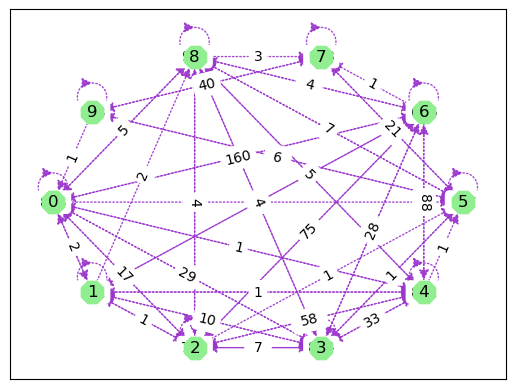

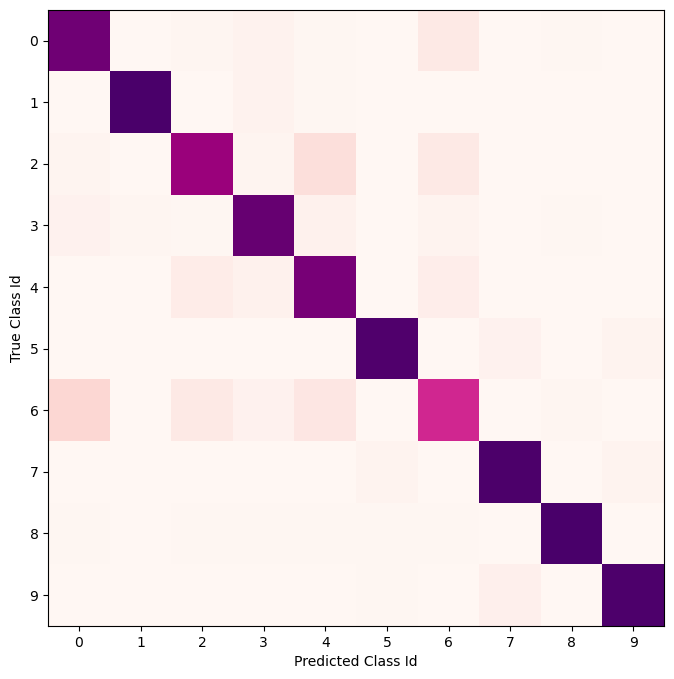

In [16]:
class_labels = [str(i) for i in range(10)]

plot_graph_confusion_matrix(class_labels,confusion_mat,wandb_log=True)
plot_heatmap_confusion_matrix(confusion_mat,wandb_log=True)

### Trying out for MNIST

In [17]:
## train-test data is got from the mnist fashion import data call
## now this data is being flattened, i.e each image into a 1d array
## then flattened train data is split into 80% train and 20% validation data.


seed = 76 #setting this as seed wherever randomness comes

(x_train,y_train),(x_test,y_test) = mnist.load_data()

x_train_flattened = x_train.flatten().reshape(x_train.shape[0],-1)/255
x_test_flattened = x_test.flatten().reshape(x_test.shape[0],-1)/255


#np.random.seed(seed)
random_num_generator = np.random.RandomState(seed)


validation_indices = random_num_generator.choice(x_train_flattened.shape[0],int(0.1*x_train_flattened.shape[0]),replace=False)
train_indices = np.array(list(set(np.arange(x_train_flattened.shape[0])).difference(set(validation_indices))))

x_train_data = x_train_flattened[train_indices]
y_train_data = y_train[train_indices]

x_validation_data = x_train_flattened[validation_indices]
y_validation_data = y_train[validation_indices]


In [18]:

number_of_hidden_layers = 4
neurons_per_hidden_layer = 64
initialization = "xavier"
activation = "tanh"
batch_size = 32
lr = 1e-4
l2_param = 0.5
optimiser = "nadam"
epochs = 25

loss =  "cross_entropy" #"mean_squared_error"

print_val_accuracy = True
log_wandb_data = False

seed = 76


nn = NeuralNetwork(seed=seed)


nn.createNNet(number_of_hidden_layers=number_of_hidden_layers,neurons_per_hidden_layer=[neurons_per_hidden_layer]*4,initialization = initialization,activation=activation)

optim = Optimiser()

optim.train(nn,[x_train_data,y_train_data],[x_validation_data,y_validation_data],optimiser,lr=lr,epochs=epochs,batch_size=batch_size,l2_param=l2_param,print_val_accuracy=True,loss_type=loss,log_wandb_data=log_wandb_data)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 91.15%  Avg. Loss : 0.31
Validation Accuracy : 91.22%  Avg. Loss : 0.31


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 93.2%  Avg. Loss : 0.23
Validation Accuracy : 92.97%  Avg. Loss : 0.25


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 94.36%  Avg. Loss : 0.19
Validation Accuracy : 93.97%  Avg. Loss : 0.21


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 95.19%  Avg. Loss : 0.16
Validation Accuracy : 94.58%  Avg. Loss : 0.19


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 95.84%  Avg. Loss : 0.14
Validation Accuracy : 94.93%  Avg. Loss : 0.17


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 96.29%  Avg. Loss : 0.12
Validation Accuracy : 95.23%  Avg. Loss : 0.16


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 96.74%  Avg. Loss : 0.11
Validation Accuracy : 95.53%  Avg. Loss : 0.15


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 97.13%  Avg. Loss : 0.1
Validation Accuracy : 95.73%  Avg. Loss : 0.14


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 97.39%  Avg. Loss : 0.09
Validation Accuracy : 95.92%  Avg. Loss : 0.14


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 97.62%  Avg. Loss : 0.08
Validation Accuracy : 95.92%  Avg. Loss : 0.13


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 97.81%  Avg. Loss : 0.07
Validation Accuracy : 96.02%  Avg. Loss : 0.13


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.01%  Avg. Loss : 0.07
Validation Accuracy : 96.15%  Avg. Loss : 0.13


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.2%  Avg. Loss : 0.06
Validation Accuracy : 96.37%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.39%  Avg. Loss : 0.06
Validation Accuracy : 96.47%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.57%  Avg. Loss : 0.05
Validation Accuracy : 96.45%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.7%  Avg. Loss : 0.05
Validation Accuracy : 96.57%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.81%  Avg. Loss : 0.04
Validation Accuracy : 96.63%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.92%  Avg. Loss : 0.04
Validation Accuracy : 96.62%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.03%  Avg. Loss : 0.03
Validation Accuracy : 96.68%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.13%  Avg. Loss : 0.03
Validation Accuracy : 96.72%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.19%  Avg. Loss : 0.03
Validation Accuracy : 96.73%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.26%  Avg. Loss : 0.03
Validation Accuracy : 96.77%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.33%  Avg. Loss : 0.02
Validation Accuracy : 96.8%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.38%  Avg. Loss : 0.02
Validation Accuracy : 96.8%  Avg. Loss : 0.13


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.41%  Avg. Loss : 0.02
Validation Accuracy : 96.77%  Avg. Loss : 0.13


In [21]:

number_of_hidden_layers = 4
neurons_per_hidden_layer = 128
initialization = "xavier"
activation = "tanh"
batch_size = 32
lr = 1e-3
l2_param = 0.005
optimiser = "nadam"
epochs = 25

loss =  "cross_entropy" #"mean_squared_error"

print_val_accuracy = True
log_wandb_data = False

seed = 76


nn = NeuralNetwork(seed=seed)


nn.createNNet(number_of_hidden_layers=number_of_hidden_layers,neurons_per_hidden_layer=[neurons_per_hidden_layer]*4,initialization = initialization,activation=activation)

optim = Optimiser()

optim.train(nn,[x_train_data,y_train_data],[x_validation_data,y_validation_data],optimiser,lr=lr,epochs=epochs,batch_size=batch_size,l2_param=l2_param,print_val_accuracy=True,loss_type=loss,log_wandb_data=log_wandb_data)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 95.23%  Avg. Loss : 0.16
Validation Accuracy : 94.02%  Avg. Loss : 0.2


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 96.82%  Avg. Loss : 0.1
Validation Accuracy : 95.25%  Avg. Loss : 0.16


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 97.38%  Avg. Loss : 0.08
Validation Accuracy : 96.02%  Avg. Loss : 0.14


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.21%  Avg. Loss : 0.06
Validation Accuracy : 96.55%  Avg. Loss : 0.13


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.15%  Avg. Loss : 0.06
Validation Accuracy : 96.3%  Avg. Loss : 0.14


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.41%  Avg. Loss : 0.05
Validation Accuracy : 96.53%  Avg. Loss : 0.13


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.65%  Avg. Loss : 0.04
Validation Accuracy : 96.57%  Avg. Loss : 0.13


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.57%  Avg. Loss : 0.04
Validation Accuracy : 96.43%  Avg. Loss : 0.15


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.95%  Avg. Loss : 0.03
Validation Accuracy : 96.72%  Avg. Loss : 0.14


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.01%  Avg. Loss : 0.03
Validation Accuracy : 96.75%  Avg. Loss : 0.14


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.01%  Avg. Loss : 0.03
Validation Accuracy : 97.05%  Avg. Loss : 0.14


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.95%  Avg. Loss : 0.03
Validation Accuracy : 96.93%  Avg. Loss : 0.15


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.38%  Avg. Loss : 0.02
Validation Accuracy : 97.23%  Avg. Loss : 0.13


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.81%  Avg. Loss : 0.04
Validation Accuracy : 96.37%  Avg. Loss : 0.17


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.79%  Avg. Loss : 0.04
Validation Accuracy : 96.45%  Avg. Loss : 0.18


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.99%  Avg. Loss : 0.03
Validation Accuracy : 96.58%  Avg. Loss : 0.16


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.48%  Avg. Loss : 0.02
Validation Accuracy : 97.42%  Avg. Loss : 0.13


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.36%  Avg. Loss : 0.02
Validation Accuracy : 97.08%  Avg. Loss : 0.15


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.69%  Avg. Loss : 0.01
Validation Accuracy : 97.22%  Avg. Loss : 0.14


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.15%  Avg. Loss : 0.03
Validation Accuracy : 96.85%  Avg. Loss : 0.17


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.61%  Avg. Loss : 0.01
Validation Accuracy : 97.33%  Avg. Loss : 0.15


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.67%  Avg. Loss : 0.01
Validation Accuracy : 97.42%  Avg. Loss : 0.15


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.55%  Avg. Loss : 0.02
Validation Accuracy : 97.47%  Avg. Loss : 0.14


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.34%  Avg. Loss : 0.02
Validation Accuracy : 96.77%  Avg. Loss : 0.17


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.77%  Avg. Loss : 0.01
Validation Accuracy : 97.32%  Avg. Loss : 0.14


In [23]:

number_of_hidden_layers = 4
neurons_per_hidden_layer = 128
initialization = "xavier"
activation = "tanh"
batch_size = 32
lr = 1e-4
l2_param = 0.005
optimiser = "nadam"
epochs = 25

loss =  "cross_entropy" #"mean_squared_error"

print_val_accuracy = True
log_wandb_data = False

seed = 76


nn = NeuralNetwork(seed=seed)


nn.createNNet(number_of_hidden_layers=number_of_hidden_layers,neurons_per_hidden_layer=[neurons_per_hidden_layer]*4,initialization = initialization,activation=activation)

optim = Optimiser()

optim.train(nn,[x_train_data,y_train_data],[x_validation_data,y_validation_data],optimiser,lr=lr,epochs=epochs,batch_size=batch_size,l2_param=l2_param,print_val_accuracy=True,loss_type=loss,log_wandb_data=log_wandb_data)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 91.99%  Avg. Loss : 0.27
Validation Accuracy : 91.92%  Avg. Loss : 0.28


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 94.03%  Avg. Loss : 0.2
Validation Accuracy : 93.5%  Avg. Loss : 0.23


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 95.22%  Avg. Loss : 0.16
Validation Accuracy : 94.42%  Avg. Loss : 0.19


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 96.05%  Avg. Loss : 0.14
Validation Accuracy : 95.1%  Avg. Loss : 0.17


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 96.65%  Avg. Loss : 0.11
Validation Accuracy : 95.47%  Avg. Loss : 0.15


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 97.12%  Avg. Loss : 0.1
Validation Accuracy : 95.75%  Avg. Loss : 0.14


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 97.51%  Avg. Loss : 0.08
Validation Accuracy : 96.12%  Avg. Loss : 0.13


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 97.81%  Avg. Loss : 0.07
Validation Accuracy : 96.2%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.09%  Avg. Loss : 0.07
Validation Accuracy : 96.45%  Avg. Loss : 0.11


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.29%  Avg. Loss : 0.06
Validation Accuracy : 96.72%  Avg. Loss : 0.11


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.52%  Avg. Loss : 0.05
Validation Accuracy : 96.95%  Avg. Loss : 0.11


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.69%  Avg. Loss : 0.05
Validation Accuracy : 97.0%  Avg. Loss : 0.1


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.82%  Avg. Loss : 0.04
Validation Accuracy : 97.07%  Avg. Loss : 0.1


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 98.94%  Avg. Loss : 0.04
Validation Accuracy : 97.03%  Avg. Loss : 0.1


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.09%  Avg. Loss : 0.03
Validation Accuracy : 97.13%  Avg. Loss : 0.1


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.18%  Avg. Loss : 0.03
Validation Accuracy : 97.08%  Avg. Loss : 0.1


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.26%  Avg. Loss : 0.03
Validation Accuracy : 97.05%  Avg. Loss : 0.1


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.33%  Avg. Loss : 0.02
Validation Accuracy : 97.1%  Avg. Loss : 0.11


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.37%  Avg. Loss : 0.02
Validation Accuracy : 97.12%  Avg. Loss : 0.11


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.45%  Avg. Loss : 0.02
Validation Accuracy : 97.12%  Avg. Loss : 0.11


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.51%  Avg. Loss : 0.02
Validation Accuracy : 97.12%  Avg. Loss : 0.11


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.6%  Avg. Loss : 0.01
Validation Accuracy : 97.1%  Avg. Loss : 0.11


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.67%  Avg. Loss : 0.01
Validation Accuracy : 97.12%  Avg. Loss : 0.11


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.72%  Avg. Loss : 0.01
Validation Accuracy : 97.08%  Avg. Loss : 0.12


  0%|          | 0/54000 [00:00<?, ?it/s]

Training   Accuracy : 99.73%  Avg. Loss : 0.01
Validation Accuracy : 97.12%  Avg. Loss : 0.12


#### Important Considerations:

1. To avoid the use of autograd/diff packages, the closed form of the derivatives is computed before hand and plugged as and when required here.

2. All hidden layers are a fully connected layer, i.e there is a weight from each neuron in the present layer to every neuron in the next layer.

3. It is assumed that all the hidden layers use the same activation function.

4. The backprop code is based on the algorithm in https://iitm-pod.slides.com/arunprakash_ai/cs6910-lecture-4/fullscreen#/0/70/8

5. It assumes that the loss used is cross entropy loss and the output activation is softmax. These assumptions are to avoid the need to depend on autograd packages, as the closed form of the derivatives in the chain rule could be now directly computed

6. Regularization adds model complexity to the objective, this helps to prevent overfitting, but still the loss as a metric would be just the L(theta).


#### Some Observations So Far:

1. Random Normal initialization is doing better than Random Uniform in general. Hence default would be Random Normal.

2. Xavier Uniform initialization is doing bettter than Xavier Normal in general. Hence default would be Xavier Uniform.



### References:

1. http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf [xavier initializatization]
2. An alternative, but equivalent expression of softmax, to avoid overflow errors [https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python]